In [73]:
##This is a pytorch implement for HybridSN 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import spectral
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
##hypeperameters and experimental settings
RANDOM_SEED=666
DATASET = 'IP'    ## PU  IP  SA  
TRAIN_RATE = 0.1  ## ratio of training data
VAL_RATE = 0.1    ## ratio of valuating data
EPOCH = 10    ##number of epoch
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 256
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components
PATCH_SIZE = 25 

In [3]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'dataset')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas/Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas/Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU/PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU/PaviaU_gt.mat'))['paviaU_gt']
    return data, labels


In [5]:
data,label = loadData(DATASET)
NUM_CLASS = label.max()

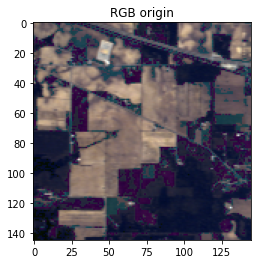

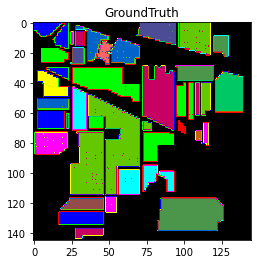

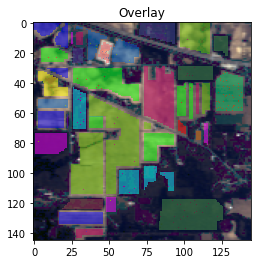

In [6]:
## display HSI
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin')
gt_view = spectral.imshow(classes=label, title='GroundTruth')
view = spectral.imshow(data,(30,20,10),classes=label)
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [7]:
## show 3D cube
# %matplotlib auto
# spectral.view_cube(data,(30,20,10))   ## depend on wxpython and pyopengl

In [8]:
def applyPCA(X, numComponents=15):
    """PCA processing

    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional): number of reserved components. Defaults to 15.

    Returns:
        newX: _description_
    """
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [9]:
data,pca = applyPCA(data,N_PCA)
data.shape

(145, 145, 15)

In [10]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [11]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

In [31]:
np.count_nonzero(train_gt)

1024

  class   train_num  val_num   test_num   total   
    1         5         4         37        46    
    2        143       143       1142      1428   
    3         83        83       664       830    
    4         24        24       189       237    
    5         48        48       387       483    
    6         73        73       584       730    
    7         3         3         22        28    
    8         48        48       382       478    
    9         2         2         16        20    
    10        97        97       778       972    
    11       245       245       1965      2455   
    12        59        59       475       593    
    13        20        21       164       205    
    14       126       127       1012      1265   
    15        39        39       308       386    
    16        9         9         75        93    
  total      1024      1025      8200     10249   


ImageView object:
  Interpolation       :  <default>

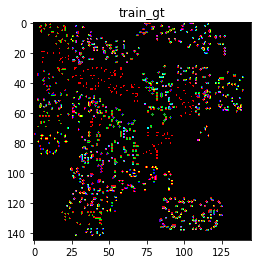

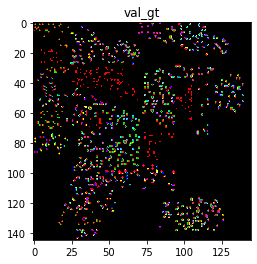

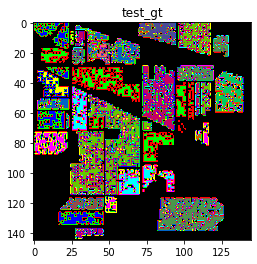

In [38]:
## display sampling info
sample_report = f"{'class': ^10}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{i: ^10}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
spectral.imshow(classes=train_gt, title='train_gt')
spectral.imshow(classes=val_gt, title='val_gt')
spectral.imshow(classes=test_gt, title='test_gt')

In [49]:
print(label.shape)
v = np.pad(label,(2,2),'constant',constant_values = 0)
print(v.shape)

(145, 145)
(149, 149)


In [74]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
        """
        super(PatchSet, self).__init__()
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        data = torch.from_numpy(data)
        label = torch.Tensor([label])
        return data, label


In [76]:
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
test_data = PatchSet(data, test_gt, PATCH_SIZE)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
test_loader = DataLoader(test_data,BATCH_SIZE,shuffle= True)

In [78]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 25, 25]), tensor([11.]))

In [60]:
## defination of HybridSN
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.name = 'HybridSN'
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        # print(self.x1_shape)
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        # print(self.x2_shape)
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out
    

net = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS) 
summary(net, input_size=(1,1,N_PCA,PATCH_SIZE,PATCH_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
HybridSN                                 --                        --
├─Sequential: 1-1                        [1, 8, 9, 23, 23]         --
│    └─Conv3d: 2-1                       [1, 8, 9, 23, 23]         512
│    └─ReLU: 2-2                         [1, 8, 9, 23, 23]         --
├─Sequential: 1-2                        [1, 16, 5, 21, 21]        --
│    └─Conv3d: 2-3                       [1, 16, 5, 21, 21]        5,776
│    └─ReLU: 2-4                         [1, 16, 5, 21, 21]        --
├─Sequential: 1-3                        [1, 32, 3, 19, 19]        --
│    └─Conv3d: 2-5                       [1, 32, 3, 19, 19]        13,856
│    └─ReLU: 2-6                         [1, 32, 3, 19, 19]        --
├─Sequential: 1-4                        [1, 64, 17, 17]           --
│    └─Conv2d: 2-7                       [1, 64, 17, 17]           55,360
│    └─ReLU: 2-8                         [1, 64, 17, 17]           --
├─S